TransferFunctionContinuous(
array([6.66666667e+10]),
array([1.00000000e+00, 6.66666667e+03]),
dt: None
)


Text(0, 0.5, 'H(f)/Rf')

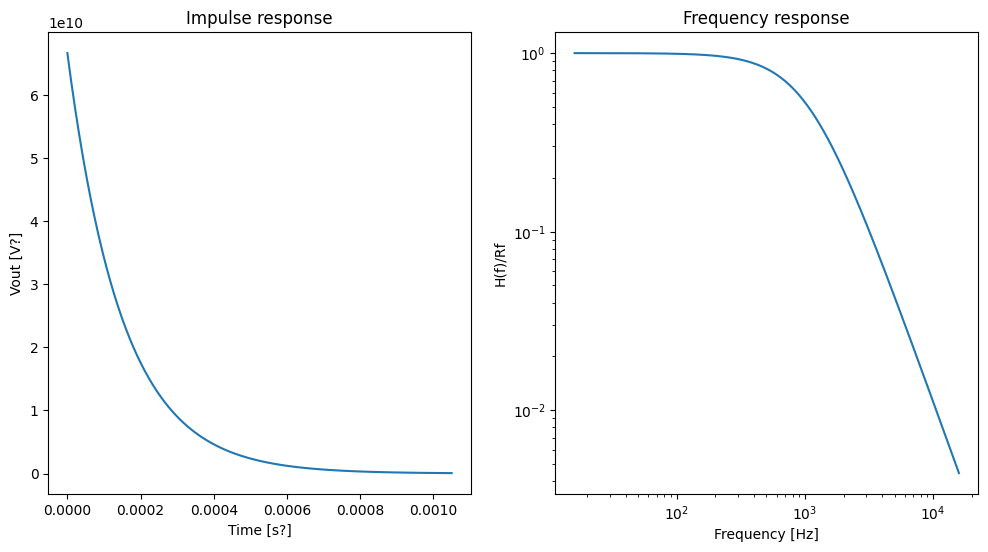

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

# xfer function: -R/(1+sRC) = [0*s - R] / [RC*s + 1]
Rf = 1e7    # ohms (feedback resistor)
Cf = 15e-12 # farads (feedback cap)
sys = signal.lti([0, Rf], [Rf*Cf, 1])
print(sys)

tt, yt = sys.impulse()
ff, yf = sys.freqresp() # ff is in rad/sec; yf are complex magnitudes
ff /= (2*np.pi)  # frequency in hertz

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
axs[0].plot(tt, yt)
axs[0].set_title("Impulse response")
axs[0].set_xlabel("Time [s?]")
axs[0].set_ylabel("Vout [V?]")
#
axs[1].plot(ff, yf/Rf)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_title("Frequency response")
axs[1].set_xlabel("Frequency [Hz]")
axs[1].set_ylabel("H(f)/Rf")
# t = np.linspace(0, 5, 150)
# v_in = np.random.uniform(-0.005,0.005,150)+5
# tout, y, x = signal.lsim(sys, v_in, t)
# plt.plot(t, v_in)
# plt.plot(t[5:], y[5:])

9.639667704949713e-06
9.492844174056484e-06


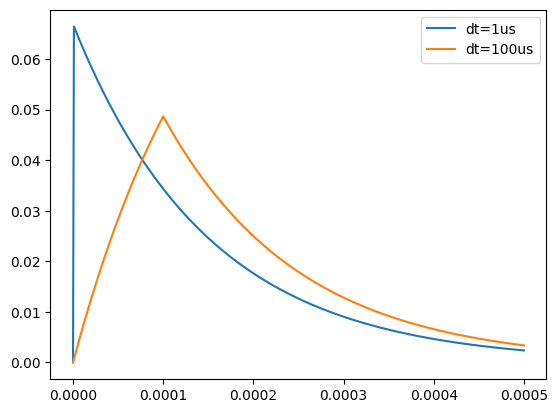

In [36]:
# Vin = linsp

# inject 1 pC of charge in a top-hat pulse of 1 us width
# so I_on * dt = 1pC => I_on = 1pC/dt = 1pC/1e-6 = 1uA
nn = 1000000
tt = np.linspace(0, 500, num=nn) # us
II_1us = np.zeros_like(tt)
II_100us = np.zeros_like(tt)

II_1us[np.where(tt<1)[0]] = 1e-6 # amps
II_100us[np.where(tt<1e2)[0]] = 1e-8 # amps

tt *= 1e-6 # seconds

tout, Vout_1us, _ = sys.output(II_1us, tt)
tout, Vout_100us, _ = sys.output(II_100us, tt)

plt.plot(tout, Vout_1us, label='dt=1us')
plt.plot(tout, Vout_100us, label='dt=100us')
plt.legend()

int1 = np.trapz(Vout_1us, tout)
int100 = np.trapz(Vout_100us, tout)
print(f"Inint1)
print(int100)